In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [12]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
MAX_LENGTH = 10  # a larger dataset

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [13]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['tu es tres contrariee', 'you re very upset']


In [14]:
pairs[0]

['je vais bien', 'i m ok']

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
from sklearn.model_selection import train_test_split

def get_data(batch_size = 32 , test_size=0.2):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
    first_pairs, test_pairs = train_test_split(pairs, test_size=test_size, random_state=42)
    train_pairs, valid_pairs = train_test_split(first_pairs, test_size=test_size, random_state=42)

    def prepare_dataset(pairs):
        n = len(pairs)
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

        for idx, (inp, tgt) in enumerate(pairs):
            inp_ids = indexesFromSentence(input_lang, inp)
            tgt_ids = indexesFromSentence(output_lang, tgt)
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            input_ids[idx, :len(inp_ids)] = inp_ids
            target_ids[idx, :len(tgt_ids)] = tgt_ids

        return TensorDataset(torch.LongTensor(input_ids).to(device),
                             torch.LongTensor(target_ids).to(device))

    train_data = prepare_dataset(train_pairs)
    test_data = prepare_dataset(test_pairs)
    valid_data = prepare_dataset(valid_pairs)

    # Creation of DataLoaders
    train_sampler = RandomSampler(train_data)
    valid_sampler = RandomSampler(valid_data)
    test_sampler = SequentialSampler(test_data)

    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return input_lang, output_lang, pairs, train_dataloader, valid_dataloader, test_dataloader

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [18]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
def showPlot(train_losses, test_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss per Epoch')
    plt.legend()
    plt.show()

In [20]:
def sentenceFromTensor(lang, tensor):
    words = [lang.index2word[idx.item()] for idx in tensor if idx.item() not in (SOS_token, EOS_token)]
    return ' '.join(words)

def evaluate_bleu(dataloader, encoder, decoder, input_lang, output_lang):
    references = []
    candidates = []
    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

            for i in range(input_tensor.size(0)):
                candidate = sentenceFromTensor(output_lang, torch.argmax(decoder_outputs[i], dim=1))
                reference = sentenceFromTensor(output_lang, target_tensor[i])
                candidates.append(candidate.split())
                references.append([reference.split()])

    return corpus_bleu(references, candidates, smoothing_function=SmoothingFunction().method4)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate_test(dataloader, encoder, decoder, criterion):
    with torch.no_grad():
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()
        return total_loss / len(dataloader)


In [21]:
def train(train_dataloader,valid_dataloader, test_dataloader, encoder, decoder, n_epochs, input_lang, output_lang, learning_rate=0.001, print_every=1):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    train_losses = []
    test_losses = []
    valid_losses = []
    train_bleu_scores = []
    test_bleu_scores = []
    valid_bleu_scores = []

    start = time.time()

    for epoch in range(1, n_epochs + 1):
        encoder.train()
        decoder.train()
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_losses.append(train_loss)

        encoder.eval()
        decoder.eval()
        valid_loss = evaluate_test(valid_dataloader, encoder, decoder, criterion)
        valid_losses.append(valid_loss)
        test_loss = evaluate_test(test_dataloader, encoder, decoder, criterion)
        test_losses.append(test_loss)

        train_bleu_score = evaluate_bleu(train_dataloader, encoder, decoder, input_lang, output_lang)
        valid_bleu_score = evaluate_bleu(valid_dataloader, encoder, decoder, input_lang, output_lang)
        test_bleu_score = evaluate_bleu(test_dataloader, encoder, decoder, input_lang, output_lang)
        train_bleu_scores.append(train_bleu_score)
        valid_bleu_scores.append(valid_bleu_score)
        test_bleu_scores.append(test_bleu_score)
        print(f'========== epoch : {epoch} ========== ')
        print(f'\nTrain Loss: {train_loss:.4f},Valid Loss : {valid_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'\nTrain BLEU: {train_bleu_score:.4f}, Valid BLEU: {valid_bleu_score:.4f},Test BLEU: {test_bleu_score:.4f}')

        if epoch % print_every == 0:
            print(f'Epoch {epoch} ===============  Train Loss: {train_loss:.4f},Valid Loss : {valid_loss:.4f}, Test Loss: {test_loss:.4f}, Train BLEU: {train_bleu_score:.4f}, Test BLEU: {test_bleu_score:.4f}')
            print(f'{timeSince(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.0f}%)')

    return train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores

# Example usage:
# encoder = EncoderRNN(input_size, hidden_size).to(device)
# decoder = DecoderRNN(hidden_size, output_size).to(device)
# train_losses, test_losses, train_bleu_scores, test_bleu_scores = train(train_dataloader, test_dataloader, encoder, decoder, n_epochs, input_lang, output_lang)


In [22]:
input_lang, output_lang, pairs, train_dataloader, valid_dataloader, test_dataloader = get_data()

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [ ]:
%%time
hidden_size = 128
batch_size = 32

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, encoder, decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.8933,Valid Loss : 2.2725, Test Loss: 2.1869

Train BLEU: 0.0198, Valid BLEU: 0.0265,Test BLEU: 0.0262
========== epoch : 2 ========== 

Train Loss: 2.0124,Valid Loss : 1.9583, Test Loss: 1.8753

Train BLEU: 0.0688, Valid BLEU: 0.0587,Test BLEU: 0.0666
========== epoch : 3 ========== 

Train Loss: 1.7252,Valid Loss : 1.7736, Test Loss: 1.6865

Train BLEU: 0.1037, Valid BLEU: 0.0939,Test BLEU: 0.1004
========== epoch : 4 ========== 

Train Loss: 1.5410,Valid Loss : 1.6630, Test Loss: 1.5754

Train BLEU: 0.1300, Valid BLEU: 0.1176,Test BLEU: 0.1251
========== epoch : 5 ========== 

Train Loss: 1.4004,Valid Loss : 1.5843, Test Loss: 1.4966

Train BLEU: 0.1417, Valid BLEU: 0.1293,Test BLEU: 0.1410
========== epoch : 6 ========== 

Train Loss: 1.2828,Valid Loss : 1.5183, Test Loss: 1.4337

Train BLEU: 0.1636, Valid BLEU: 0.1417,Test BLEU: 0.1582
========== epoch : 7 ========== 

Train Loss: 1.1786,Valid Loss : 1.4758, Test Loss: 1.3905

Train B

In [23]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [24]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> elles sont a moi
= they re mine
< they re mine mine <EOS>

> c est un lourdaud
= he s a slowpoke
< he is a tennis champion <EOS>

> il ne va pas progresser
= he is not going to get ahead
< he is not going to visit you tomorrow <EOS>

> j en ai assez de tes recriminations
= i m sick of your complaints
< i m sick of listening to her complaints <EOS>

> elles sont en danger
= they re in danger
< they re in danger tom <EOS>

> je ne vais pas citer de noms
= i m not going to name names
< i m not going to argue with this wet weather

> nous allons gravir cette montagne
= we are going to climb that mountain
< we are going to climb that mountain <EOS>

> tu as toujours a te plaindre
= you are always complaining
< you are always complaining about the food <EOS>

> vous ne pensez pas clairement
= you re not thinking clearly
< you re not going to visit you feel <EOS>

> nous sommes dos au mur
= we re up against the wall
< we are sure i turned off the gas <EOS>



In [27]:
def tran(sentence,encoder,decoder):
    output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    print(output_sentence)

In [ ]:
tran('je ne suis pas pret',encoder,decoder)

i m not ready to fight <EOS>


# Attention Mechanism

In [25]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [26]:
hidden_size = 128
batch_size = 32


A_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
A_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

A_train_losses, A_valid_losses, A_test_losses, A_train_bleu_scores, A_valid_bleu_scores, A_test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, A_encoder, A_decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.7610,Valid Loss : 2.1408, Test Loss: 2.0578

Train BLEU: 0.0490, Valid BLEU: 0.0521,Test BLEU: 0.0510
========== epoch : 2 ========== 

Train Loss: 1.8612,Valid Loss : 1.7974, Test Loss: 1.7167

Train BLEU: 0.1277, Valid BLEU: 0.1173,Test BLEU: 0.1339
========== epoch : 3 ========== 

Train Loss: 1.5641,Valid Loss : 1.6095, Test Loss: 1.5331

Train BLEU: 0.1616, Valid BLEU: 0.1471,Test BLEU: 0.1618
========== epoch : 4 ========== 

Train Loss: 1.3645,Valid Loss : 1.4864, Test Loss: 1.4105

Train BLEU: 0.1922, Valid BLEU: 0.1798,Test BLEU: 0.1889
========== epoch : 5 ========== 

Train Loss: 1.2068,Valid Loss : 1.4061, Test Loss: 1.3277

Train BLEU: 0.2204, Valid BLEU: 0.1980,Test BLEU: 0.2062
========== epoch : 6 ========== 

Train Loss: 1.0742,Valid Loss : 1.3401, Test Loss: 1.2536

Train BLEU: 0.2695, Valid BLEU: 0.2354,Test BLEU: 0.2423
========== epoch : 7 ========== 

Train Loss: 0.9595,Valid Loss : 1.2670, Test Loss: 1.1976

Train B

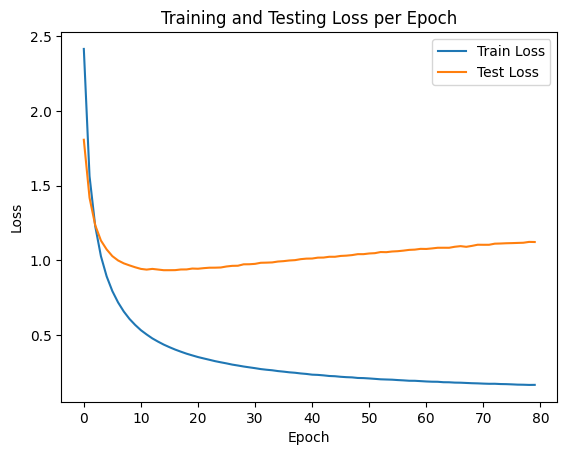

In [ ]:
showPlot(tr, ts)

In [34]:
A_encoder.eval()
A_decoder.eval()
evaluateRandomly(A_encoder, A_decoder)

> desole
= i m sorry
< i m sorry sorry but i am sorry <EOS>

> nous sommes tous dingues
= we re all crazy
< we re all crazy <EOS>

> il part pour tokyo demain
= he s leaving for tokyo tomorrow
< he s waiting for going to develop tomorrow <EOS>

> il n est qu un amateur
= he is just an amateur
< he is nothing but a gentleman <EOS>

> elles ne sont pas encore chez elles
= they re not home yet
< they re not home yet <EOS>

> je ne suis pas votre frere
= i m not your brother
< i m not your brother <EOS>

> je m en vais le mois prochain
= i am moving next month
< i am moving next month <EOS>

> je suis tres curieux
= i am very curious
< i am very curious <EOS>

> je suis ravi de te rencontrer
= i m delighted to meet you
< i m delighted to meet you <EOS>

> elle est en danger
= she s in danger
< she is currently in danger <EOS>



In [ ]:
tran('il est revenu a la maison',A_encoder,A_decoder )

he came home at home <EOS>


In [ ]:

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence,encoder,decoder):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere',A_encoder,A_decoder)

evaluateAndShowAttention('je suis trop fatigue pour conduire',A_encoder,A_decoder)

evaluateAndShowAttention('je suis desole si c est une question idiote',A_encoder,A_decoder)

evaluateAndShowAttention('je suis reellement fiere de vous',A_encoder,A_decoder)

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>
input = je suis trop fatigue pour conduire
output = i m too tired to drive a car <EOS>


<ipython-input-52-e8c5d814f91d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-52-e8c5d814f91d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


input = je suis desole si c est une question idiote
output = i m sorry if it is a stupid question <EOS>
input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


<ipython-input-35-de8308ec761d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-35-de8308ec761d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


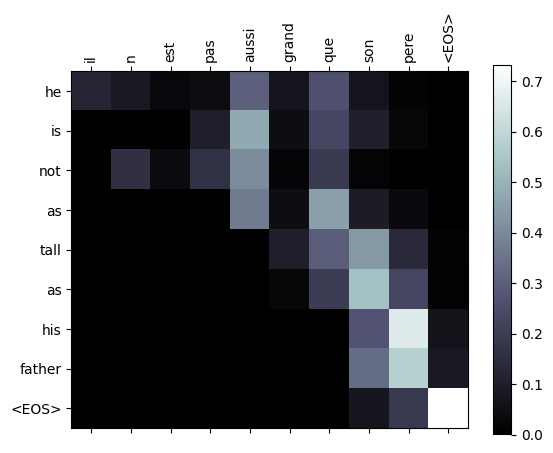

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


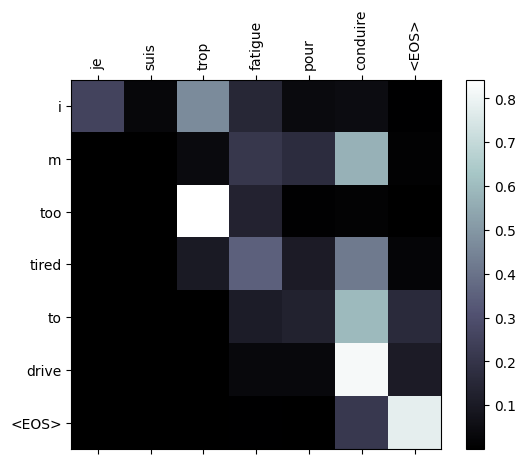

input = je suis desole si c est une question idiote
output = i m sorry if my close daughter <EOS>


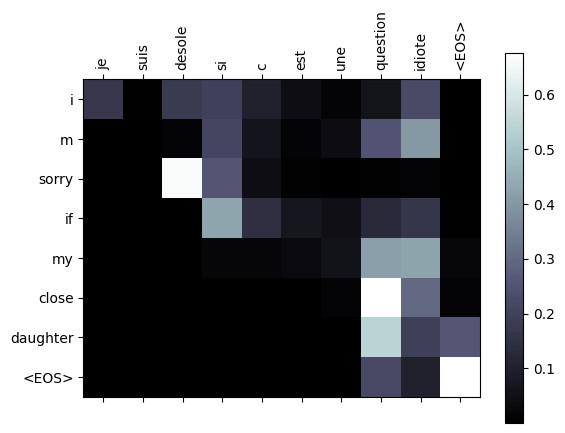

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


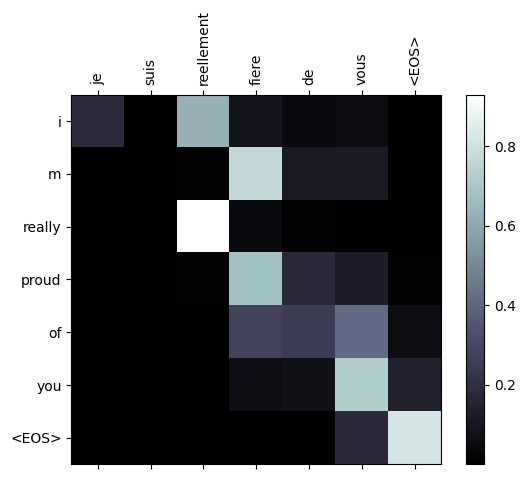

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

# Function to display attention
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# Function to evaluate and display attention
def evaluateAndShowAttention(input_sentence, encoder, decoder):
    # Assuming evaluate function returns output_words and attentions
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

# Check if CUDA is available and move models to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A_encoder.to(device)
A_decoder.to(device)

# Example sentences to evaluate
evaluateAndShowAttention('il n est pas aussi grand que son pere', A_encoder, A_decoder)
evaluateAndShowAttention('je suis trop fatigue pour conduire', A_encoder, A_decoder)
evaluateAndShowAttention('je suis desole si c est une question idiote', A_encoder, A_decoder)
evaluateAndShowAttention('je suis reellement fiere de vous', A_encoder, A_decoder)

# LSTM

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded)
        return output, (hidden, cell)

class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden  # Initialize decoder's initial hidden state with encoder's last hidden state
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # Detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        return output, hidden

In [ ]:
%%time
hidden_size = 128
batch_size = 32


L_encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
L_decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)

L_train_losses, L_valid_losses, L_test_losses, L_train_bleu_scores, L_valid_bleu_scores, L_test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, L_encoder, L_decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.9795,Valid Loss : 2.3175, Test Loss: 2.2364

Train BLEU: 0.0345, Valid BLEU: 0.0362,Test BLEU: 0.0313
========== epoch : 2 ========== 

Train Loss: 2.0729,Valid Loss : 2.0333, Test Loss: 1.9533

Train BLEU: 0.0771, Valid BLEU: 0.0698,Test BLEU: 0.0784
========== epoch : 3 ========== 

Train Loss: 1.8263,Valid Loss : 1.8629, Test Loss: 1.7736

Train BLEU: 0.1179, Valid BLEU: 0.1052,Test BLEU: 0.1173
========== epoch : 4 ========== 

Train Loss: 1.6482,Valid Loss : 1.7385, Test Loss: 1.6524

Train BLEU: 0.1492, Valid BLEU: 0.1326,Test BLEU: 0.1497
========== epoch : 5 ========== 

Train Loss: 1.5122,Valid Loss : 1.6541, Test Loss: 1.5678

Train BLEU: 0.1493, Valid BLEU: 0.1351,Test BLEU: 0.1477
========== epoch : 6 ========== 

Train Loss: 1.4007,Valid Loss : 1.5829, Test Loss: 1.5016

Train BLEU: 0.1639, Valid BLEU: 0.1425,Test BLEU: 0.1549
========== epoch : 7 ========== 

Train Loss: 1.3051,Valid Loss : 1.5264, Test Loss: 1.4438

Train B

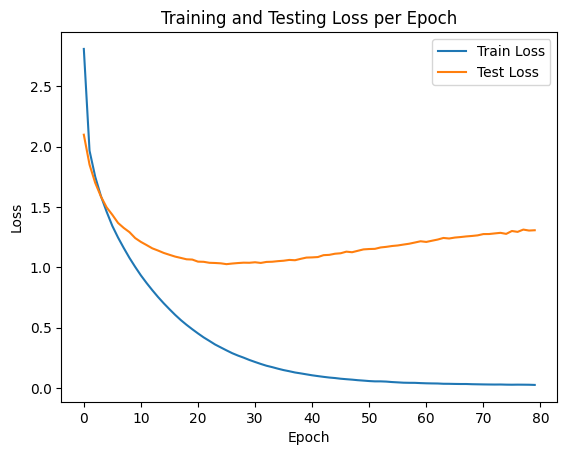

In [ ]:
showPlot(L_tr,L_ts)

In [ ]:
L_encoder.eval()
L_decoder.eval()
evaluateRandomly(L_encoder, L_decoder)

> tu es intrepide
= you re fearless
< you re kind <EOS>

> je n y suis pas interesse
= i m not interested in that
< i m not interested in that <EOS>

> je suis une travailleuse sociale
= i m a social worker
< i m a stranger here <EOS>

> je me promene dans un parc
= i m taking a walk in a park
< i m in a new career <EOS>

> vous etes tres bonne
= you re very good
< you re very good <EOS>

> il est dans la douche
= he s in the shower
< he s in the shower <EOS>

> je suis sure que tom avait une bonne raison
= i m sure tom had a good reason
< i m sure tom had a good reason <EOS>

> nous sommes trop occupees
= we re too busy
< we are too late <EOS>

> tu es la seule canadienne que je connaisse
= you re the only canadian i know
< you re the only canadian i know <EOS>

> tu es ambitieuse
= you re ambitious
< you re mad <EOS>



In [ ]:
tran('je ne suis pas pret',L_encoder,L_decoder)

i m not ready to go <EOS>


# Attention

In [28]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        # LSTM hidden state: (h, c)
        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# Constants
# SOS_token = 0  # Start of Sentence Token
# MAX_LENGTH = 10  # Assume a maximum length of sentences
# device = 'cuda'  # Assuming using CUDA


In [31]:
hidden_size = 128
batch_size = 32


LA_encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
LA_decoder = AttnDecoderLSTM(hidden_size, output_lang.n_words).to(device)

LA_train_losses, LA_valid_losses, LA_test_losses, LA_train_bleu_scores, LA_valid_bleu_scores, LA_test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, LA_encoder, LA_decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.8292,Valid Loss : 2.1873, Test Loss: 2.1088

Train BLEU: 0.0517, Valid BLEU: 0.0564,Test BLEU: 0.0553
========== epoch : 2 ========== 

Train Loss: 1.9454,Valid Loss : 1.9088, Test Loss: 1.8251

Train BLEU: 0.0954, Valid BLEU: 0.0894,Test BLEU: 0.0955
========== epoch : 3 ========== 

Train Loss: 1.6939,Valid Loss : 1.7415, Test Loss: 1.6535

Train BLEU: 0.1259, Valid BLEU: 0.1105,Test BLEU: 0.1263
========== epoch : 4 ========== 

Train Loss: 1.5209,Valid Loss : 1.6291, Test Loss: 1.5378

Train BLEU: 0.1513, Valid BLEU: 0.1348,Test BLEU: 0.1414
========== epoch : 5 ========== 

Train Loss: 1.3854,Valid Loss : 1.5466, Test Loss: 1.4544

Train BLEU: 0.1734, Valid BLEU: 0.1579,Test BLEU: 0.1681
========== epoch : 6 ========== 

Train Loss: 1.2688,Valid Loss : 1.4746, Test Loss: 1.3915

Train BLEU: 0.1999, Valid BLEU: 0.1803,Test BLEU: 0.1815
========== epoch : 7 ========== 

Train Loss: 1.1658,Valid Loss : 1.4083, Test Loss: 1.3321

Train B

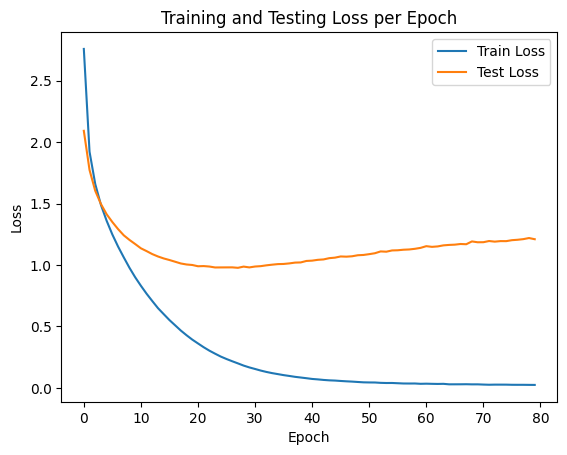

In [ ]:
showPlot(LA_tr,LA_ts)

In [ ]:
LA_encoder.eval()
LA_decoder.eval()
evaluateRandomly(LA_encoder, LA_decoder)

> vous etes toutes malades
= you re all insane
< you re all insane <EOS>

> j en ai marre d etre prudent
= i m tired of being careful
< i m sick of being sick <EOS>

> vous etes gare en double file
= you re double parked
< you re double parked <EOS>

> vous etes pleins de ressources
= you re resourceful
< you re very resourceful <EOS>

> vous etes tellement difficiles !
= you re so picky
< you are so sweet <EOS>

> ils sont tous terrifies
= they re all terrified
< they are the pet <EOS>

> il est vraiment fondu de foot
= he s really into soccer
< he s really into soccer <EOS>

> je ne suis pas medecin mais enseignant
= i m not a doctor but a teacher
< i am not a doctor but a teacher <EOS>

> nous sommes les nouveaux proprietaires
= we are the new owners
< we are the new owners <EOS>

> je ne suis pas d humeur a blaguer
= i am in no mood for joking
< i m not running to it <EOS>



In [ ]:
tran('nous ne sommes pas medecin mais enseignant',A_encoder,A_decoder) #GRU

we re not a doctor but a teacher <EOS>


In [ ]:
tran('nous ne sommes pas medecin mais enseignant',LA_encoder,LA_decoder) #LSTM

we are not a doctor but a teacher <EOS>


# Comparaison

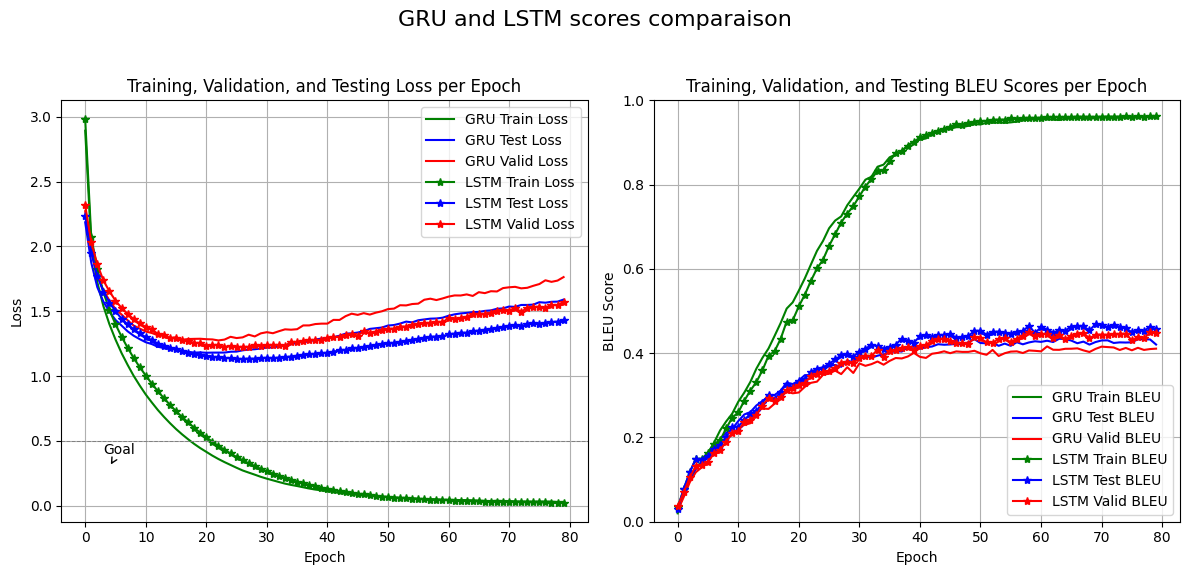

In [ ]:
# Création de la grille de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Sous-graphe 1 : Losses
axs[0].plot(train_losses, label='GRU Train Loss', color='g')
axs[0].plot(test_losses, label='GRU Test Loss',  color='b')
axs[0].plot(valid_losses, label='GRU Valid Loss',  color='r')
axs[0].plot(L_train_losses, label='LSTM Train Loss', marker='*', color='g')
axs[0].plot(L_test_losses, label='LSTM Test Loss', marker='*', color='b')
axs[0].plot(L_valid_losses, label='LSTM Valid Loss', marker='*', color='r')
axs[0].set_title('Training, Validation, and Testing Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)  # Ajouter une grille
axs[0].axhline(0.5, color='gray', linewidth=0.7, linestyle='--')  # Ajouter une ligne de référence
axs[0].annotate('Goal', xy=(4, 0.3), xytext=(3, 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'))  # Ajouter une annotation

# Sous-graphe 2 : BLEU scores
axs[1].plot(train_bleu_scores, label='GRU Train BLEU', color='g')
axs[1].plot(test_bleu_scores, label='GRU Test BLEU', color='b')
axs[1].plot(valid_bleu_scores, label='GRU Valid BLEU', color='r')
axs[1].plot(L_train_bleu_scores, label='LSTM Train BLEU', marker='*', color='g')
axs[1].plot(L_test_bleu_scores, label='LSTM Test BLEU', marker='*', color='b')
axs[1].plot(L_valid_bleu_scores, label='LSTM Valid BLEU', marker='*', color='r')
axs[1].set_title('Training, Validation, and Testing BLEU Scores per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('BLEU Score')
axs[1].legend()
axs[1].grid(True)  # Ajouter une grille
axs[1].axhline(50, color='gray', linewidth=0.7, linestyle='--')  # Ajouter une ligne de référence

# Ajouter un titre global pour la figure
fig.suptitle('GRU and LSTM scores comparaison', fontsize=16)

axs[1].set_ylim(0,1)

# Ajuster les sous-graphiques pour éviter les chevauchements
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste pour faire de la place pour le titre global

# Enregistrer la figure
fig.savefig('non_attention comparaision.png', dpi=300)

# Afficher les sous-graphiques
plt.show()

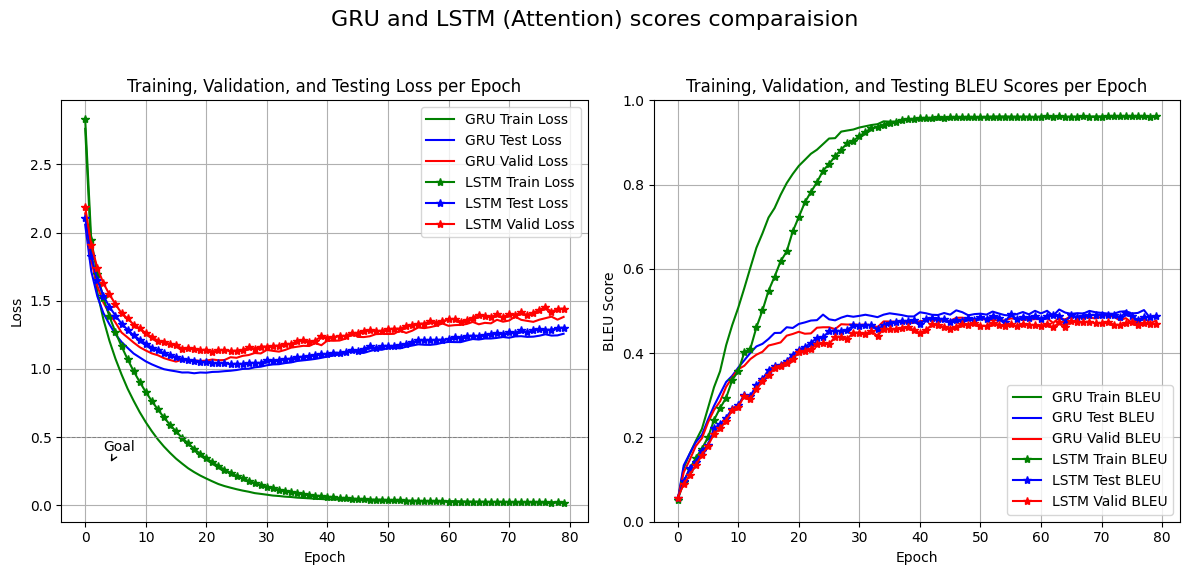

In [33]:
# Création de la grille de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Sous-graphe 1 : Losses
axs[0].plot(A_train_losses, label='GRU Train Loss', color='g')
axs[0].plot(A_test_losses, label='GRU Test Loss',  color='b')
axs[0].plot(A_valid_losses, label='GRU Valid Loss',  color='r')
axs[0].plot(LA_train_losses, label='LSTM Train Loss', marker='*', color='g')
axs[0].plot(LA_test_losses, label='LSTM Test Loss', marker='*', color='b')
axs[0].plot(LA_valid_losses, label='LSTM Valid Loss', marker='*', color='r')
axs[0].set_title('Training, Validation, and Testing Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)  # Ajouter une grille
axs[0].axhline(0.5, color='gray', linewidth=0.7, linestyle='--')  # Ajouter une ligne de référence
axs[0].annotate('Goal', xy=(4, 0.3), xytext=(3, 0.4), arrowprops=dict(facecolor='black', arrowstyle='->'))  # Ajouter une annotation

# Sous-graphe 2 : BLEU scores
axs[1].plot(A_train_bleu_scores, label='GRU Train BLEU', color='g')
axs[1].plot(A_test_bleu_scores, label='GRU Test BLEU', color='b')
axs[1].plot(A_valid_bleu_scores, label='GRU Valid BLEU', color='r')
axs[1].plot(LA_train_bleu_scores, label='LSTM Train BLEU', marker='*', color='g')
axs[1].plot(LA_test_bleu_scores, label='LSTM Test BLEU', marker='*', color='b')
axs[1].plot(LA_valid_bleu_scores, label='LSTM Valid BLEU', marker='*', color='r')
axs[1].set_title('Training, Validation, and Testing BLEU Scores per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('BLEU Score')
axs[1].legend()
axs[1].grid(True)  # Ajouter une grille
axs[1].axhline(50, color='gray', linewidth=0.7, linestyle='--')  # Ajouter une ligne de référence

# Ajouter un titre global pour la figure
fig.suptitle('GRU and LSTM (Attention) scores comparaision', fontsize=16)

axs[1].set_ylim(0,1)

# Ajuster les sous-graphiques pour éviter les chevauchements
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste pour faire de la place pour le titre global

# Enregistrer la figure
fig.savefig('GRU and LSTM (Attention) comparaision.png', dpi=300)

# Afficher les sous-graphiques
plt.show()

# TSNE

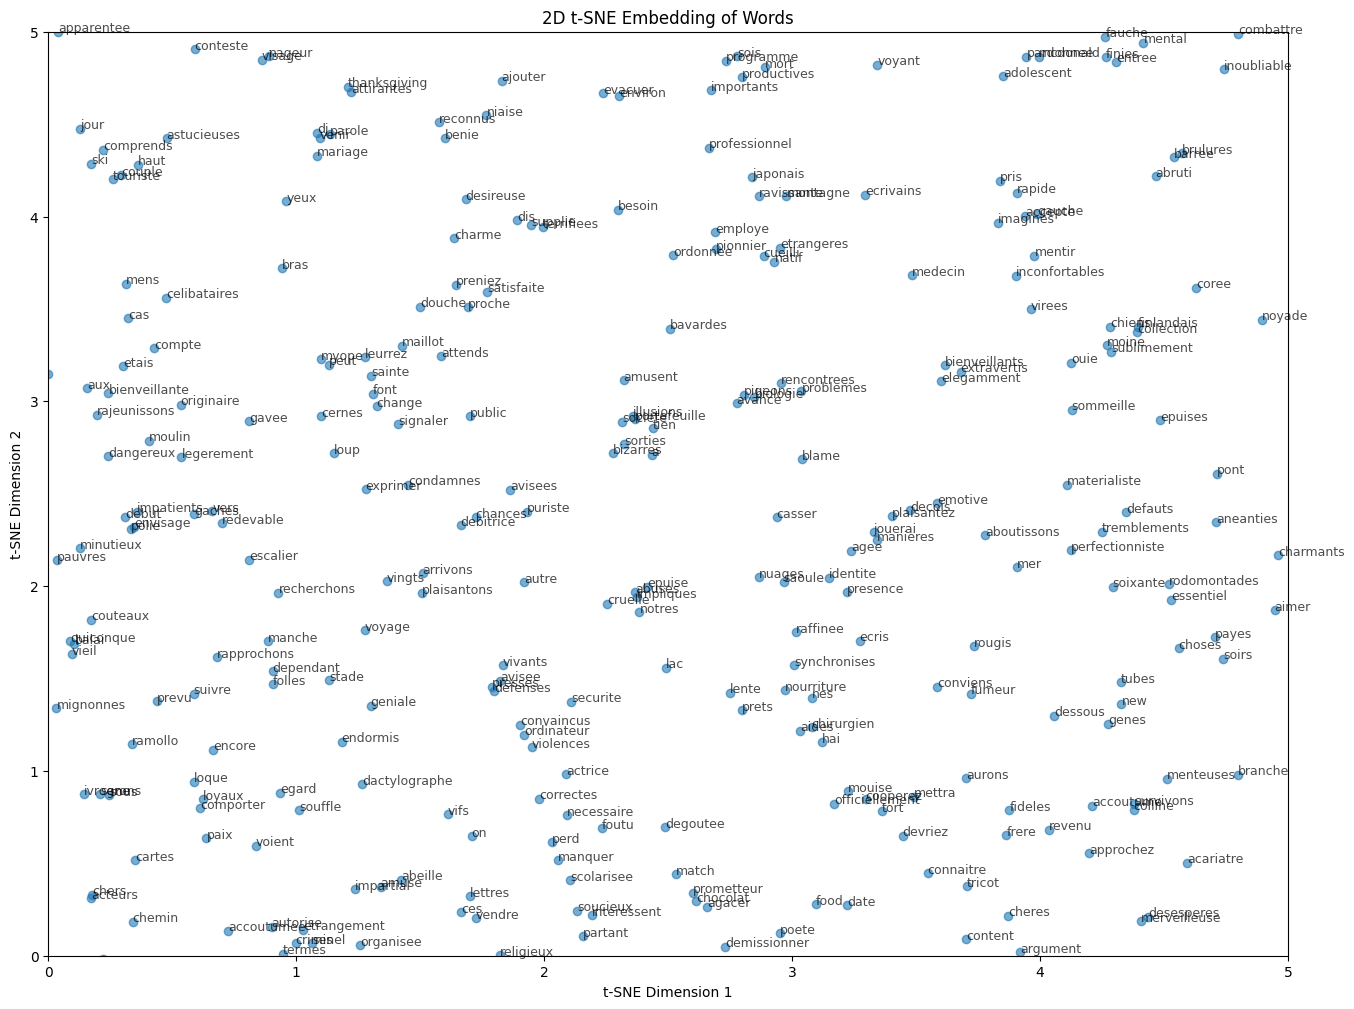

In [ ]:
encoder = EncoderRNN(input_size=input_lang.n_words, hidden_size=hidden_size)

# Get the embedding matrix
embedding_matrix = encoder.embedding.weight.detach().numpy()

# Apply t-SNE to reduce the embedding dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embedding_matrix)

# Retrieve the words from the input_lang index2word
words = [input_lang.index2word[i] for i in range(input_lang.n_words)]

# Plot the 2D embeddings
fig, ax = plt.subplots(figsize=(16, 12))
sc = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.6)

# Ajouter des annotations
for i, word in enumerate(words):
    ax.annotate(word, (embedding_2d[i, 0], embedding_2d[i, 1]), alpha=0.7, fontsize=9)

ax.set_title('2D t-SNE Embedding of Words')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

plt.show()

In [ ]:
def sentence_embedding(sentence, embedding_matrix, lang):
    indexes = indexesFromSentence(lang, sentence)
    embeddings = [embedding_matrix[idx] for idx in indexes]
    return np.mean(embeddings, axis=0)

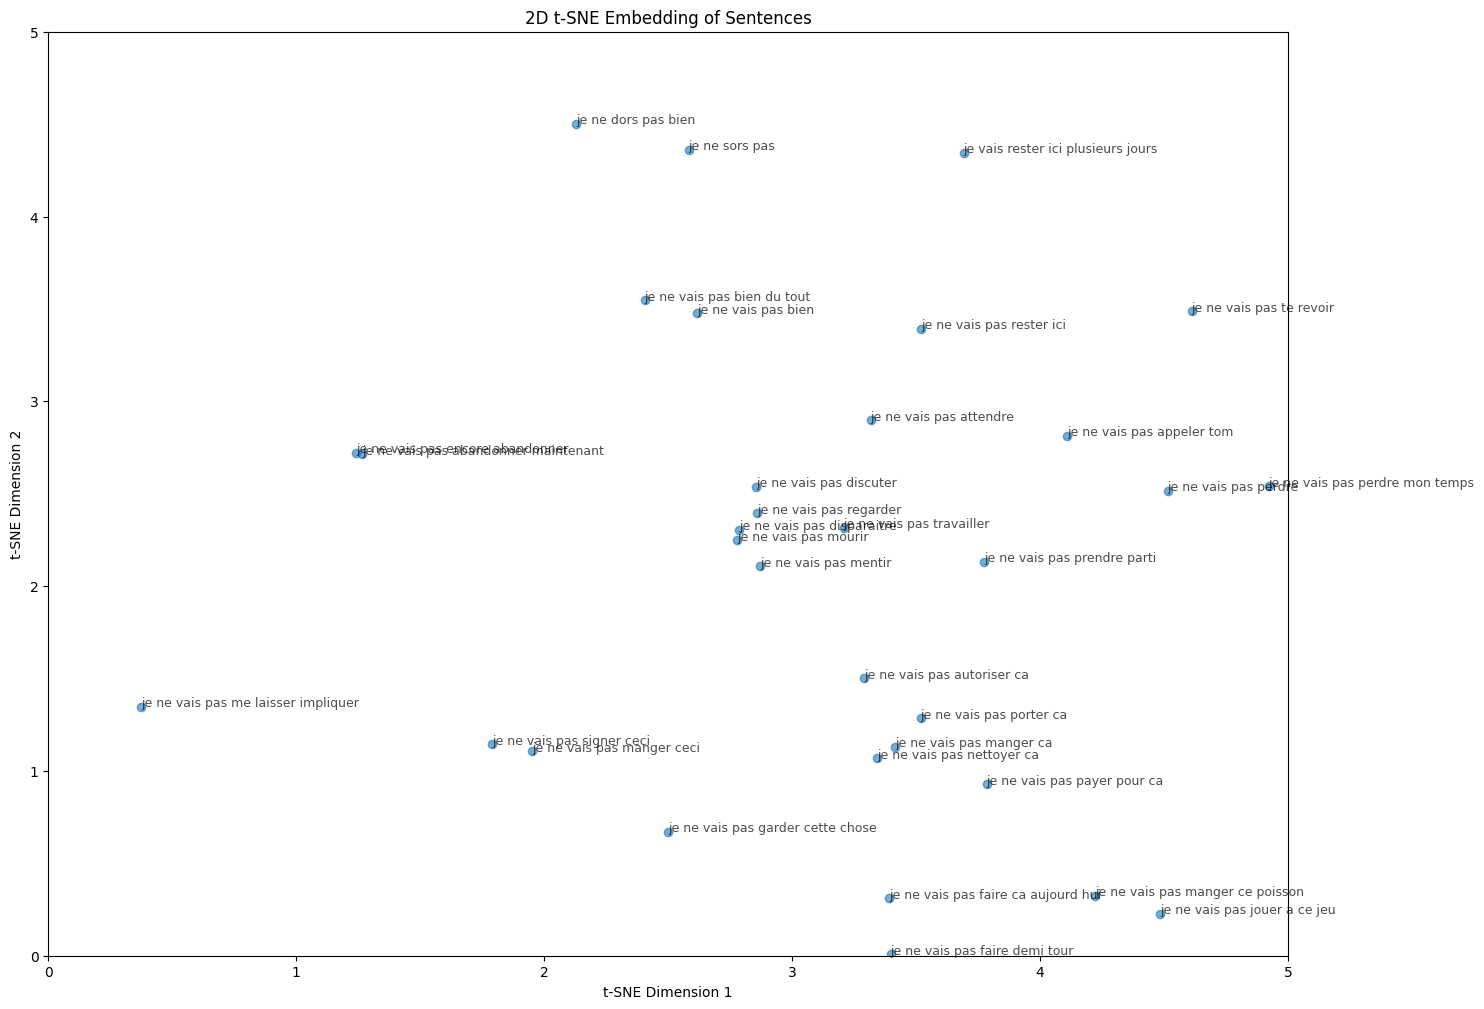

In [ ]:
encoder = EncoderRNN(input_size=input_lang.n_words, hidden_size=hidden_size)
embedding_matrix = encoder.embedding.weight.detach().numpy()

sentence_embeddings = []
sentences = []

for pair in pairs:
    sent_embedding = sentence_embedding(pair[0], embedding_matrix, input_lang)
    sentence_embeddings.append(sent_embedding)
    sentences.append(pair[0])  # Vous pouvez utiliser la phrase originale ou une version raccourcie pour l'affichage

sentence_embeddings = np.array(sentence_embeddings)

# Appliquer t-SNE sur les embeddings des phrases
tsne = TSNE(n_components=2, random_state=42)
sentence_embeddings_2d = tsne.fit_transform(sentence_embeddings)

# Afficher le graphique avec les phrases annotées
fig, ax = plt.subplots(figsize=(16, 12))
sc = ax.scatter(sentence_embeddings_2d[:, 0], sentence_embeddings_2d[:, 1], alpha=0.6)

# Annoter les points avec les phrases (ou une version raccourcie)
for i, sentence in enumerate(sentences):
    ax.annotate(sentence, (sentence_embeddings_2d[i, 0], sentence_embeddings_2d[i, 1]), alpha=0.7, fontsize=9)

ax.set_title('2D t-SNE Embedding of Sentences')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)


plt.show()